### Import required libraries

In [38]:
import os
from osgeo import gdal, osr
import pyproj as pyproj
import numpy as np
from random import randint
from scipy import ndimage
from copy import copy
import time
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

def extract_rasters(raster_path):
    raster_raw = gdal.Open(raster_path)
    raster = raster_raw.ReadAsArray()
    return raster

### INPUTS: Enter own values

Specify a unique name for the project as `save_folder`. A folder with your chosen name will be created in the results folder, and all outputs for the design will be saved there. E.g:

In [10]:
save_folder = 'Uniform_Design_Demo'

Enter path to habitat map (`hab_path`). This should be in GeoTiff format and saved in the 'raw' data folder. E.g:

In [11]:
hab_path = 'raw/HabitatMap.tif'

Enter path to invalid areas mask (if there are any you wish to exclude). This can be used to mask out inaccessible areas, or habitat categories which you do not wish to sample in. E.g:

In [36]:
mask_path = 'raw/InvalidAreasMask.tif'

If you do not wish to enter a mask, run this line:

In [31]:
mask_path = None

Enter fragmentation metric maps. This design aims to optimise the placement of sites based on different measures of fragmentation. This could be, for example, a distance to nearest habitat edge map. More than one metric can be entered. Please specify the number of maps you will enter below. E.g:

In [25]:
n_metrics = 2

Enter path to metric map one. E.g:

In [73]:
metric1_path = 'raw/DistanceToEdgeLog2.tif'

In [74]:
bins1 = 9

To spread sites evenly across the metric values, we break continous metrics into intervals. 

In [75]:
def discretize_metric(metric, mask, nbins):
    """Convert continuous metrics into discrete, using the specified number of bins"""
    imheight, imwidth = metric.shape
    # Mask out invalid areas of metric
    metric_mask = np.ma.masked_array(metric, mask=mask)
    # Break range of unmasked metric values into 'nbin' intervals
    hist, breaks, patches = plt.hist(metric_mask.compressed(), bins = nbins)
    # Assign each bin a unique integer ID
    ids = range(nbins)
    ones = np.ones((imheight, imwidth)); metric_bin = np.zeros((imheight, imwidth))
    # Loop through ID's and convert all values in each bin to corresponding id
    for ID in ids:
        # Closed on the lower bound, open on the top
        lower_lim=np.where(ones, metric_mask>=breaks[ID], 0)
        upper_lim=np.where(ones, metric_mask<breaks[ID+1], 0)
        # Make the last interval closed at the upper bound
        if ID == nbins-1:
            upper_lim = np.where(ones, metric_mask<=breaks[ID+1], 0)
        metric_bin += lower_lim*upper_lim*ID
    return metric_bin, ids, breaks

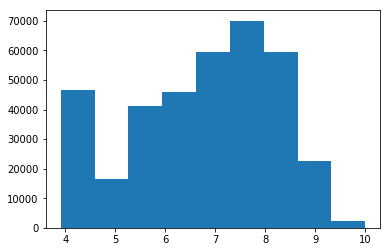

In [76]:
metric1 = extract_rasters(metric1_path)
metric1_binned, metric1_id, metric1_breaks = discretize_metric(metric1, mask, bins1)

As we can see from the histogram, some metric values are represented by larger areas of the landscape. Some, for example the high distance to edges, are only present in a small area. We wish to sample these areas uniformly with our sample sites.
Try altering the number of bins and see how the distribution changes

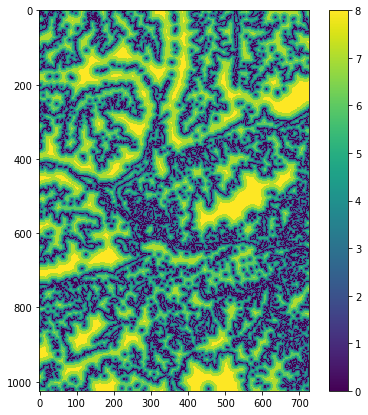

In [77]:
plt.figure(figsize=(7, 7))
plt.imshow(metric1_binned)
plt.colorbar()
plt.show()

Enter path to metric map two. E.g:

In [28]:
metric2_path = 'raw/FragmentAreaLog10.tif'

In [29]:
bins2 = 8

Again, convert the metric to discrete

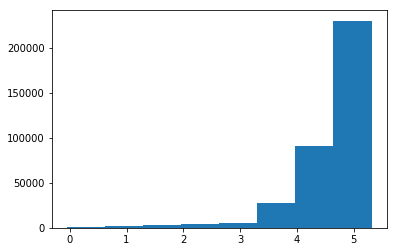

In [65]:
metric2 = extract_rasters(metric2_path)
metric2_binned, metric2_id, metric2_breaks = discretize_metric(metric2, mask, bins2)

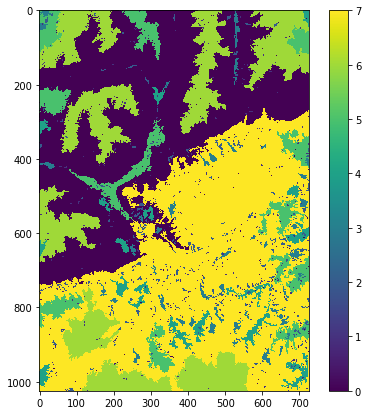

In [72]:
plt.figure(figsize=(7, 7))
plt.imshow(metric2_binned)
plt.colorbar()
plt.show()

For ```n_metrics``` larger than two, add extra paths and bin numbers in the same format. E.g:

```metric3_path = ```

```bins3 = ```

Enter an integer number of sample sites (`nsp`). E.g

In [17]:
nsp = 80

### Combine metrics for processing

We will now extend this analysis to look at combinations between multiple metrics

In [78]:
def build_df(bin_ids):
    """Create a dataframe of all combinations of IDs"""
    # Create array of all combinations
    id_mesh = np.meshgrid(*bin_ids)
    # Convert to dataframe, each row represents a unique combination of the ID's
    combo_df = pd.DataFrame([ids.flatten() for ids in id_mesh]).T
    return combo_df


def bin_metrics(input_metrics, mask, n_metrics, nbins):
    """Bin all input metric arrays into discrete ID arrays, and create a dataframe of all the
    unique combinations of these IDs"""
    binned_metrics = []
    bin_ids = []
    bin_breaks = []
    # Generate a binned version of all input metric arrays
    for i in range(n_metrics):
        metric_bin, ids, breaks = discretize_metric(input_metrics[i + 1], mask, nbins[i + 1])
        binned_metrics.append(metric_bin)  # Save all new (discretized) metric arrays
        bin_ids.append(ids)  # Save the list of all IDs present for each array
        bin_breaks.append(breaks)  # Save the bin breaks for each metric
    # Generate dataframe of all combinations of IDs between the input metric arrays
    combo_df = build_df(bin_ids)
    return binned_metrics, combo_df, bin_breaks

In [79]:
binned_metrics, combo_df, bin_breaks = bin_metrics(immetrics, mask, n_metrics, nbins)

IndexError: list index out of range

In [80]:
def generate_all_layers(binned_metrics, n_metrics, mask_inv, combo_df, nvars, nsp):
    """Create single combined ID array and calculate the optimum number of sample sites in each ID """
    imheight, imwidth = mask_inv.shape
    combo_num = len(combo_df)
    # create 3d array to store ID combo layers in
    all_layers = np.zeros((combo_num, imheight, imwidth))
    counts = []
    # Iterate through all unique ID combinations
    for i in range(combo_num):
        im_layer = np.ones((imheight, imwidth))
        for j in range(n_metrics):
            # Convert selected ID to binary for each metric, and multiply together to see where
            # combinations are in the landscape image
            im_layer = np.where(binned_metrics[j] == combo_df.iloc[i][j], 1, 0) * im_layer
        # Make sure invalid areas are set as zero
        layer_mask = im_layer * mask_inv
        counts.append(np.sum(layer_mask))  # Store the number of pixels in each unique combo layer
        all_layers[i, :, :] = layer_mask  # Save combo Id layer in 3d array
    combo_df['Counts'] = counts
    ID_df = combo_df[combo_df.Counts != 0]  # remove empty bins to create ID dataframe
    s_opt = np.float(nsp) / len(ID_df)  # optimum sample sites in each ID
    ID_df = ID_df[ID_df.Counts >= 10 * np.ceil(s_opt)]  # remove IDs with too few pixels
    s_opt = np.float(nsp) / len(ID_df)
    return all_layers, ID_df, s_opt

In [81]:
all_layers, ID_df, s_opt = generate_all_layers(binned_metrics, n_metrics, mask, combo_df, n_metrics, nsp)

NameError: name 'binned_metrics' is not defined

In [83]:
def generate_ID_im(all_layers, ID_df, nsp, savepath):
    imdepth, imheight, imwidth = all_layers.shape
    ID_im = np.zeros((imheight, imwidth))
    store_masks = np.zeros((len(ID_df), imheight, imwidth))
    counter = 0;
    unique_IDs = []
    for k in ID_df.index.values:
        store_masks[counter, :, :] = all_layers[k, :, :]
        ID_im += all_layers[k, :, :] * (counter + 1)
        unique_IDs.append(counter + 1)
        counter += 1
    # Save an ID image for adapted uniform designs
    # np.save("{0}/{1}Site_Uniform_IDim".format(savepath, nsp), ID_im)
    return store_masks, ID_im, unique_IDs

In [84]:
store_masks, ID_im, unique_IDs = generate_ID_im(all_layers, ID_df, nsp, savepath)

NameError: name 'all_layers' is not defined

#### check the number of sample sites needed to have a uniform number of sample sites in each metric bin. 

In [85]:
def upper_lower_suggest(nsp, ID_df):
    """Calculate upper and lower number of sample sites to meet uniform distribution """
    nsp = float(nsp)
    n_bins = len(ID_df)
    nsp_lower = np.floor(nsp / n_bins) * n_bins
    nsp_upper = np.ceil(nsp / n_bins) * n_bins
    return nsp_lower.astype(int), nsp_upper.astype(int)

In [39]:
if mask_path:
    mask = extract_rasters(mask_path)
else:
    mask = np.ones_like(habmap)

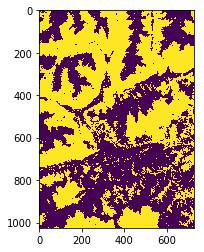

In [40]:
plt.imshow(mask)
plt.show()

### Load data

In [18]:
def get_file_info(file_path):
    file_raw = gdal.Open(file_path)
    prj = file_raw.GetProjection(); srs = osr.SpatialReference(wkt=prj)
    auth_code = srs.GetAuthorityCode(None)
    GeoT = file_raw.GetGeoTransform(); res = GeoT[1]
    file_map = file_raw.ReadAsArray()
    nbins = len(np.unique(file_map))
    return file_map, nbins, res, GeoT, auth_code

In [43]:
print('Loading {} ...'.format(hab_path))

habmap, hab_bins, res, GeoT, auth_code = get_file_info(hab_path)

print('\nNumber of habitat categories in map: {}'.format(hab_bins))
print('Pixel resolution (m): {}'.format(res))
print('GeoT info: {}'.format(GeoT))
print('Authority code: {}'.format(auth_code))

Loading raw/HabitatMap.tif ...

Number of habitat categories in map: 2
Pixel resolution (m): 30.0
GeoT info: (604343.5084861958, 30.0, 0.0, 5302852.190465175, 0.0, -30.0)
Authority code: 32759


**Plot habitat map**: Check habitat map, there should be integer values denoting the different categories.

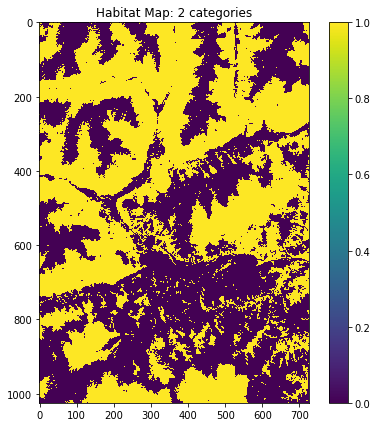

In [23]:
plt.figure(figsize=(7, 7))
plt.imshow(habmap)
plt.title('Habitat Map: {} categories'.format(len(np.unique(habmap))))
cbar = plt.colorbar()
plt.show()

In [46]:
immetrics = [habmap]
nbins = [hab_bins]

for i in range(n_metrics):
    metric = extract_rasters(metric_path[i])
    immetrics.append(metric)
    nbins.append(bins[i])
    
    
    

NameError: name 'metric_path' is not defined

In [ ]:
def generate_id_list(unique_IDs, s_opt, nsp, ID_df):
    """Create a list where each unique ID is repeated by s_opt"""
    id_rep = np.repeat(unique_IDs, np.floor(s_opt))
    # If there is a difference in the number of sample sites and the number of elements
    # in id_rep then add extras randomly from the list of IDs, without replacement
    diff = nsp - len(id_rep)
    while diff >= len(unique_IDs):
        id_rep = np.hstack([id_rep, unique_IDs])
        diff = nsp - len(id_rep)
    extra_sites = np.random.choice(unique_IDs, nsp - len(id_rep), replace=False)
    id_list = np.hstack([id_rep, extra_sites])  # Now list of length nsp
    # Randomly permute list
    id_mix = np.random.choice(id_list, nsp, replace=False)
    # If nsp is less than the number of IDs (i.e one or less sample per ID),
    # then create a reduced dataframe
    if len(id_mix) < len(unique_IDs):
        id_mix.sort()
        ID_df = ID_df.iloc[id_mix]
    ID_df['Freq'] = np.unique(id_mix, return_counts=True)[1]
    return id_mix, ID_df

In [86]:
id_mix, ID_df = generate_id_list(unique_IDs, s_opt, nsp, ID_df)

NameError: name 'generate_id_list' is not defined

## Generate uniform design

In [11]:
def generate_uniform_design(id_mix, unique_IDs, store_masks):

    imdepth, imheight, imwidth = store_masks.shape
    dist_im = np.ones((imheight, imwidth))
    sites = np.ones((imheight, imwidth))
    x_vals = []
    y_vals = []
    loop_count = 0
    nsp = len(id_mix)

    for i in id_mix:

        # Select binary map relating to selected ID
        maskID = unique_IDs.index(i)
        # Mask out any regions of EDT not in ID
        layer = store_masks[maskID, :, :] * dist_im

        # Extract coords of pixels with maximum distance value and choose one at random
        dist_mx = zip(*np.where(layer == layer.max()))
        idx = randint(0, len(dist_mx) - 1)
        x, y = dist_mx[idx]

        # Save coordinates
        x_vals = np.append(x_vals, x)
        y_vals = np.append(y_vals, y)

        # Add selected site to sites array as 0 (feature pixel)
        sites[x, y] = 0

        # Compute EDT from all placed sites
        dist_im = ndimage.distance_transform_edt(sites)
        loop_count += 1

    xy0 = np.hstack([x_vals, y_vals])
    return xy0

In [12]:
x_unif, y_unif = generate_uniform_design(id_mix, unique_IDs, store_masks)

Plotting site 1
Plotting site 2
Plotting site 3
Plotting site 4
Plotting site 5
Plotting site 6
Plotting site 7
Plotting site 8
Plotting site 9
Plotting site 10
Plotting site 11
Plotting site 12
Plotting site 13
Plotting site 14
Plotting site 15
Plotting site 16
Plotting site 17
Plotting site 18
Plotting site 19
Plotting site 20
Plotting site 21
Plotting site 22
Plotting site 23
Plotting site 24
Plotting site 25
Plotting site 26
Plotting site 27
Plotting site 28
Plotting site 29
Plotting site 30
Stratified sample design complete!


# Results

Generate results folder for given project (if the folder already exists it will not overwrite, additional results will just be added to the existing folder)

In [13]:
directory = 'results/{}'.format(save_folder)
if not os.path.exists(directory):
    os.makedirs(directory)

# Create unique time stamp to add to file names (to avoid overwriting)
ts = time.gmtime()
ts = time.strftime("%Y_%m_%d_%H%M%S", ts)

print('Results will be saved in the folder {}'.format(directory))
print('Files will start with the time stamp {}'.format(ts))

Results will be saved in the folder results/Stratified_Design_Demo
Files will start with the time stamp 2019_09_27_165245


### Plot Design

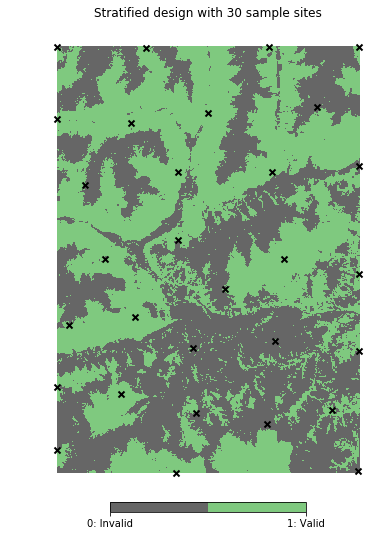

In [14]:
plt.figure(figsize=(7, 9))
plt.imshow(mask, cmap=plt.cm.get_cmap('Accent_r', 2))
plt.title('{} design with {} sample sites'.format('Stratified', len(x_strat)))
plt.axis('off')
cbar = plt.colorbar(fraction=0.02, orientation='horizontal', pad=0.01)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0: Invalid', '1: Valid'])
plt.scatter(y_strat, x_strat, c='black', marker='x', linewidth=2)
plt.savefig('{}/{}_{}Site_Stratified_Plot.tif'.format(directory, ts, nsp))
plt.show()

The Stratified Design Algorithm (SDA) produces a layout where sites are spread evenly spatially, given the constraints of the valid sample areas. 

### Save the design

The below function converts the (x, y) coordinates specifying pixels in the image to longitude and latitude coordinates. Geo-information extracted from the input "invalid areas mask" is used to transform the points to long-lat. 

In [24]:
file_raw = gdal.Open(mask_path)

srs = osr.SpatialReference()
srs.ImportFromWkt(file_raw.GetProjection())

0

In [27]:
srsLatLong = srs.CloneGeogCS()

In [29]:
ct = osr.CoordinateTransformation(srs, srsLatLong)

In [30]:
ct

<osgeo.osr.CoordinateTransformation; proxy of <Swig Object of type 'OSRCoordinateTransformationShadow *' at 0x0000021AC6B9B2A0> >

In [35]:
print(ct.TransformPoint(1000, 1000))

(80.88127412159001, -85.53507302812842, 0.0)


In [37]:
indataset = gdal.Open( mask_path, gdal.GA_ReadOnly)
geomatrix = indataset.GetGeoTransform()

In [40]:
pixel_x = 1; pixel_y = 1
line 

X = geomatrix[0] + geomatrix[1] * pixel_x + geomatrix[2] * line
Y = geomatrix[3] + geomatrix[4] * pixel_y + geomatrix[5] * line

# shift to the center of the pixel
X += geomatrix[1] / 2.0
Y += geomatrix[5] / 2.0

# build spatial coordinate system 
srs = osr.SpatialReference()
if srs.ImportFromWkt(indataset.GetPojection()) != 0:
    print("Error: cannot import projection '%s'" % indataset.GetProjection())
    sys.exit(1)
    
srsLatLong = srs.CloneGeogCS()
ct = osr.CoordinateTransformation(srs, srsLatLong)
(int, lat, height) = ct.TransformPoint(X, Y)


NameError: name 'line' is not defined

In [15]:
def LongLatConvert(x, y, GeoT, auth_code):
    x_proj = x * GeoT[1] + GeoT[0] + (GeoT[1] / 2)
    y_proj = y * GeoT[5] + GeoT[3] + (GeoT[5] / 2)
    p1 = pyproj.Proj(init='EPSG:'+auth_code)
    longlat = p1(x_proj, y_proj, inverse=True)
    return longlat

In [16]:
# Convert from row/col to projected
longlat = LongLatConvert(x_strat, y_strat, GeoT, auth_code)

RuntimeError: b'no arguments in initialization list'

Save the coordinates in a csv file...

In [32]:
# Reformat and save to csv
result = pd.DataFrame(list(zip(*longlat)), columns = ['longitude','latitude'])
result.index += 1; result['row'] = x_strat; result['col'] = y_strat
result['sampled'] = np.array([0]*nsp)
csv_filename = '{}_{}Site_Stratified.csv'.format(ts, nsp)
result.to_csv('{}/{}'.format(directory, csv_filename), index_label='site')
print('Design results saved as a csv in {} directory \nFile name: {}'.format(directory, csv_filename))

NameError: name 'longlat' is not defined

### Example output:

Print the first few lines of the csv file...

In [96]:
view_csv = pd.read_csv('{}/{}'.format(directory, csv_filename))

In [97]:
view_csv.head()

,site,longitude,latitude,row,col,sampled
0,1,172.575026,-42.517812,834.0,377.0,0
1,2,172.268461,-42.419761,0.0,0.0,0
2,3,172.336065,-42.615136,174.0,726.0,0
3,4,172.447568,-42.422772,491.0,19.0,0
4,5,172.638446,-42.415069,1015.0,0.0,0


Columns consist of:
* A **site** ID
* The coordinates in **longitude** and **latitude**
* The coordinates in **row** and **column** (corresponding to pixels in image)
* A **sampled** column: This is used when generating an *adapted design*. When conducting the survey sites which have been sampled can be tagged with a 1 in this column. Unsampled sites remain tagged with a 0. **For example see demo_adapted_stratified notebook**. 